In [1]:
from nltk import word_tokenize 
from nltk.util import ngrams
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from time import time
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.metrics.pairwise import cosine_similarity

import gensim.downloader as gensim_downloader
import os.path as path
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import scipy
import spacy
import re
import multiprocessing

/Users/iudalov/code/py/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
_DATA_PREFIX = "us-patent-phrase-to-phrase-matching"

_TRAIN = path.join(_DATA_PREFIX, "train.csv")
_SUBMIT = path.join(_DATA_PREFIX, "test.csv")

train_csv = pd.read_csv(_TRAIN)
submission_csv = pd.read_csv(_SUBMIT)

# UNCOMENT ON FIRST LAUNCH
# nltk.download()


# word 2 vec model
w2v = gensim_downloader.load("glove-wiki-gigaword-300")

def _list_similarities(ls):
    similarities = list()
    for w1 in ls[0].split():
        for w2 in ls[1].split():
            try:
                similarities.append(w2v.similarity(w1, w2))
            except:
                pass
    if len(similarities) == 0:
        return [0]
    return similarities


def _avg_word_similarity(ls):
    s = _list_similarities(ls)
    return sum(s) / len(s)


def _max_word_similarity(ls):
    return max(_list_similarities(ls))


def _norm_edit_distance(ls):
    return nltk.edit_distance(ls[0], ls[1]) / (max(len(ls[0]), len(ls[1])))


def _sentence_avg_vec(s):
    embeds = list()
    for w in s.split():
        try:
            embeds.append(w2v.get_vector(w))
        except:
            pass
    return np.average(np.array(embeds), axis=0) if len(embeds) != 0 else np.zeros(300)


def prepare_dataset(pre_df):
    df = pre_df.copy()
    df["context_alpha"] = df["context"].map(lambda x: x[:1])
    df["context_num"] = df["context"].map(lambda x: int(x[1:]))
    w_pair = ["target", "anchor"]

    df["anchor_vec"] = df["anchor"].map(_sentence_avg_vec)
    df["target_vec"] = df["target"].map(_sentence_avg_vec)
    df["cos_distance"] = df[["anchor_vec", "target_vec"]].apply(lambda x: cosine_similarity([x[0]], [x[1]])[0][0], axis=1)


    df["norm_edit_distance"] = df[w_pair].apply(_norm_edit_distance, axis=1)  
    df["avg_sim"] = df[w_pair].apply(_avg_word_similarity, axis=1)
    df["max_sim"] = df[w_pair].apply(_max_word_similarity, axis=1)

    return train_test_split(df.sample(frac=1).reset_index(drop=True), test_size=0.2)

train, test = prepare_dataset(train_csv)
train.head()

,id,anchor,target,context,score,context_alpha,context_num,anchor_vec,target_vec,cos_distance,norm_edit_distance,avg_sim,max_sim
31490,cb795b06204d89f4,final roll,printing roll,B41,0.50,B,41,"[0.250009, 0.2846325, -0.024019, -0.035115004,...","[0.192904, 0.09868249, 0.1027095, -0.318845, -...",0.571118,0.461538,0.343903,1.000000
13339,ba8fbe5b70ce4192,carburization,heat rash,B23,0.00,B,23,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.678795, -0.265765, 0.32356, -0.601765, -0.3...",0.000000,0.846154,0.000000,0.000000
17894,9d2558f365745909,panel frame,reflecting fabrics,F24,0.25,F,24,"[0.2875785, -0.019524999, -0.330545, -0.55806,...","[-0.026081003, -0.231197, 0.1368155, -0.100601...",0.213335,0.777778,0.131624,0.166992
16650,a40abb6b3bc90687,offset table,booklet containing measurements,G06,0.50,G,6,"[-0.06401999, 0.435255, 0.20697999, -0.2843675...","[-0.30832466, 0.22574668, 0.018086672, -0.1399...",0.264344,0.774194,0.128688,0.238573
10638,b2e9380e766656a8,materially less,substantially less,H01,0.75,H,1,"[0.14051999, -0.136785, -0.13712999, -0.135897...","[-0.30869502, -0.0060150027, -0.16310999, 0.15...",0.768012,0.388889,0.518841,1.000000


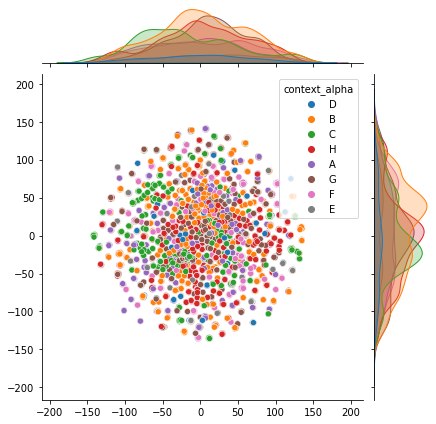

In [3]:
# show reduced embeds
def show_embeds(embeds, colors):
    dtf = np.array([np.array(e) for e in embeds], dtype="f")
    reduc = PCA(n_components=50).fit_transform(dtf)
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    points = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    #PCA(n_components=2).fit_transform(dtf)
    sns.jointplot(x=points[:,0], y=points[:,1], hue=colors) #, kind="kde")
    
show_embeds(test["anchor_vec"], test["context_alpha"])

In [4]:
# fit catboost regressor with custom metric
class CatBoostEvalMetricPearson(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        # the larger metric value the better
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        preds = np.array(approxes[0])
        target = np.array(target)
        return np.corrcoef(target, preds)[0, 1], 0


cols = ["max_sim", "avg_sim", "norm_edit_distance", "context_alpha", "context_num", "cos_distance"]
cat_features = [3, 4]  

model = CatBoostRegressor(eval_metric=CatBoostEvalMetricPearson())

model.fit(
    Pool(
        data=train[cols],
        cat_features=cat_features,
        label=train["score"]
    ),
    eval_set=Pool(
        data=test[cols],
        cat_features=cat_features,
        label=test["score"]
    )
)

/Users/iudalov/code/py/venv/lib/python3.8/site-packages/catboost/core.py:2005: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


Learning rate set to 0.086479
0:	learn: 0.5362362	test: 0.5483694	best: 0.5483694 (0)	total: 69.2ms	remaining: 1m 9s
1:	learn: 0.5463353	test: 0.5532007	best: 0.5532007 (1)	total: 78.3ms	remaining: 39s
2:	learn: 0.5489573	test: 0.5554317	best: 0.5554317 (2)	total: 86.4ms	remaining: 28.7s
3:	learn: 0.5532000	test: 0.5587746	best: 0.5587746 (3)	total: 93.3ms	remaining: 23.2s
4:	learn: 0.5571961	test: 0.5627261	best: 0.5627261 (4)	total: 101ms	remaining: 20s
5:	learn: 0.5603852	test: 0.5641006	best: 0.5641006 (5)	total: 108ms	remaining: 17.8s
6:	learn: 0.5640036	test: 0.5658525	best: 0.5658525 (6)	total: 114ms	remaining: 16.2s
7:	learn: 0.5660134	test: 0.5682673	best: 0.5682673 (7)	total: 121ms	remaining: 15s
8:	learn: 0.5676233	test: 0.5694901	best: 0.5694901 (8)	total: 128ms	remaining: 14.1s
9:	learn: 0.5690782	test: 0.5699280	best: 0.5699280 (9)	total: 134ms	remaining: 13.3s
10:	learn: 0.5694157	test: 0.5707715	best: 0.5707715 (10)	total: 141ms	remaining: 12.7s
11:	learn: 0.5694077	tes

100:	learn: 0.6022553	test: 0.5904118	best: 0.5904336 (99)	total: 586ms	remaining: 5.21s
101:	learn: 0.6023958	test: 0.5904788	best: 0.5904788 (101)	total: 590ms	remaining: 5.2s
102:	learn: 0.6024822	test: 0.5904752	best: 0.5904788 (101)	total: 594ms	remaining: 5.17s
103:	learn: 0.6026909	test: 0.5904177	best: 0.5904788 (101)	total: 599ms	remaining: 5.16s
104:	learn: 0.6027374	test: 0.5904939	best: 0.5904939 (104)	total: 603ms	remaining: 5.14s
105:	learn: 0.6029064	test: 0.5905298	best: 0.5905298 (105)	total: 608ms	remaining: 5.12s
106:	learn: 0.6032568	test: 0.5908525	best: 0.5908525 (106)	total: 614ms	remaining: 5.12s
107:	learn: 0.6033995	test: 0.5909821	best: 0.5909821 (107)	total: 618ms	remaining: 5.1s
108:	learn: 0.6035441	test: 0.5910392	best: 0.5910392 (108)	total: 623ms	remaining: 5.09s
109:	learn: 0.6038042	test: 0.5911883	best: 0.5911883 (109)	total: 629ms	remaining: 5.09s
110:	learn: 0.6040746	test: 0.5913276	best: 0.5913276 (110)	total: 634ms	remaining: 5.08s
111:	learn: 0

222:	learn: 0.6209090	test: 0.5975359	best: 0.5975359 (222)	total: 1.17s	remaining: 4.06s
223:	learn: 0.6210440	test: 0.5975477	best: 0.5975477 (223)	total: 1.17s	remaining: 4.05s
224:	learn: 0.6212949	test: 0.5974963	best: 0.5975477 (223)	total: 1.18s	remaining: 4.05s
225:	learn: 0.6214399	test: 0.5975817	best: 0.5975817 (225)	total: 1.18s	remaining: 4.04s
226:	learn: 0.6216248	test: 0.5976519	best: 0.5976519 (226)	total: 1.18s	remaining: 4.04s
227:	learn: 0.6218162	test: 0.5977271	best: 0.5977271 (227)	total: 1.19s	remaining: 4.03s
228:	learn: 0.6219078	test: 0.5977987	best: 0.5977987 (228)	total: 1.2s	remaining: 4.03s
229:	learn: 0.6220518	test: 0.5977480	best: 0.5977987 (228)	total: 1.2s	remaining: 4.03s
230:	learn: 0.6221460	test: 0.5978002	best: 0.5978002 (230)	total: 1.21s	remaining: 4.03s
231:	learn: 0.6222364	test: 0.5977896	best: 0.5978002 (230)	total: 1.21s	remaining: 4.02s
232:	learn: 0.6223464	test: 0.5977496	best: 0.5978002 (230)	total: 1.22s	remaining: 4.02s
233:	learn: 

339:	learn: 0.6347149	test: 0.6001545	best: 0.6002455 (333)	total: 1.75s	remaining: 3.41s
340:	learn: 0.6347475	test: 0.6001417	best: 0.6002455 (333)	total: 1.76s	remaining: 3.4s
341:	learn: 0.6349489	test: 0.6003163	best: 0.6003163 (341)	total: 1.76s	remaining: 3.4s
342:	learn: 0.6350478	test: 0.6003898	best: 0.6003898 (342)	total: 1.77s	remaining: 3.39s
343:	learn: 0.6351636	test: 0.6003551	best: 0.6003898 (342)	total: 1.77s	remaining: 3.39s
344:	learn: 0.6353074	test: 0.6004035	best: 0.6004035 (344)	total: 1.78s	remaining: 3.38s
345:	learn: 0.6353746	test: 0.6004198	best: 0.6004198 (345)	total: 1.78s	remaining: 3.38s
346:	learn: 0.6354421	test: 0.6004290	best: 0.6004290 (346)	total: 1.79s	remaining: 3.37s
347:	learn: 0.6355055	test: 0.6004570	best: 0.6004570 (347)	total: 1.79s	remaining: 3.36s
348:	learn: 0.6356100	test: 0.6004602	best: 0.6004602 (348)	total: 1.8s	remaining: 3.36s
349:	learn: 0.6357233	test: 0.6004877	best: 0.6004877 (349)	total: 1.8s	remaining: 3.35s
350:	learn: 0.

456:	learn: 0.6457568	test: 0.6017529	best: 0.6017670 (455)	total: 2.34s	remaining: 2.78s
457:	learn: 0.6458867	test: 0.6016993	best: 0.6017670 (455)	total: 2.34s	remaining: 2.77s
458:	learn: 0.6459280	test: 0.6016896	best: 0.6017670 (455)	total: 2.35s	remaining: 2.77s
459:	learn: 0.6460744	test: 0.6017450	best: 0.6017670 (455)	total: 2.35s	remaining: 2.76s
460:	learn: 0.6462034	test: 0.6017787	best: 0.6017787 (460)	total: 2.36s	remaining: 2.76s
461:	learn: 0.6463176	test: 0.6017264	best: 0.6017787 (460)	total: 2.36s	remaining: 2.75s
462:	learn: 0.6463796	test: 0.6017203	best: 0.6017787 (460)	total: 2.37s	remaining: 2.75s
463:	learn: 0.6465521	test: 0.6017025	best: 0.6017787 (460)	total: 2.38s	remaining: 2.75s
464:	learn: 0.6466437	test: 0.6016573	best: 0.6017787 (460)	total: 2.38s	remaining: 2.74s
465:	learn: 0.6467309	test: 0.6016750	best: 0.6017787 (460)	total: 2.39s	remaining: 2.73s
466:	learn: 0.6468016	test: 0.6017588	best: 0.6017787 (460)	total: 2.39s	remaining: 2.73s
467:	learn

570:	learn: 0.6554912	test: 0.6024434	best: 0.6024892 (555)	total: 2.92s	remaining: 2.19s
571:	learn: 0.6555690	test: 0.6024461	best: 0.6024892 (555)	total: 2.93s	remaining: 2.19s
572:	learn: 0.6556125	test: 0.6024340	best: 0.6024892 (555)	total: 2.93s	remaining: 2.19s
573:	learn: 0.6556326	test: 0.6024302	best: 0.6024892 (555)	total: 2.94s	remaining: 2.18s
574:	learn: 0.6556704	test: 0.6024498	best: 0.6024892 (555)	total: 2.94s	remaining: 2.17s
575:	learn: 0.6558332	test: 0.6023585	best: 0.6024892 (555)	total: 2.95s	remaining: 2.17s
576:	learn: 0.6559408	test: 0.6024149	best: 0.6024892 (555)	total: 2.95s	remaining: 2.16s
577:	learn: 0.6560515	test: 0.6024169	best: 0.6024892 (555)	total: 2.96s	remaining: 2.16s
578:	learn: 0.6561376	test: 0.6023754	best: 0.6024892 (555)	total: 2.96s	remaining: 2.15s
579:	learn: 0.6561860	test: 0.6023667	best: 0.6024892 (555)	total: 2.97s	remaining: 2.15s
580:	learn: 0.6563057	test: 0.6023311	best: 0.6024892 (555)	total: 2.97s	remaining: 2.14s
581:	learn

685:	learn: 0.6639054	test: 0.6029302	best: 0.6030456 (653)	total: 3.51s	remaining: 1.61s
686:	learn: 0.6640094	test: 0.6028543	best: 0.6030456 (653)	total: 3.51s	remaining: 1.6s
687:	learn: 0.6640399	test: 0.6028439	best: 0.6030456 (653)	total: 3.52s	remaining: 1.6s
688:	learn: 0.6640975	test: 0.6028816	best: 0.6030456 (653)	total: 3.52s	remaining: 1.59s
689:	learn: 0.6641430	test: 0.6028872	best: 0.6030456 (653)	total: 3.53s	remaining: 1.58s
690:	learn: 0.6641611	test: 0.6028824	best: 0.6030456 (653)	total: 3.53s	remaining: 1.58s
691:	learn: 0.6641716	test: 0.6028839	best: 0.6030456 (653)	total: 3.54s	remaining: 1.57s
692:	learn: 0.6642627	test: 0.6028490	best: 0.6030456 (653)	total: 3.54s	remaining: 1.57s
693:	learn: 0.6642811	test: 0.6028655	best: 0.6030456 (653)	total: 3.55s	remaining: 1.56s
694:	learn: 0.6643203	test: 0.6028068	best: 0.6030456 (653)	total: 3.56s	remaining: 1.56s
695:	learn: 0.6643244	test: 0.6028067	best: 0.6030456 (653)	total: 3.56s	remaining: 1.55s
696:	learn: 

799:	learn: 0.6706394	test: 0.6027582	best: 0.6030456 (653)	total: 4.09s	remaining: 1.02s
800:	learn: 0.6707511	test: 0.6028097	best: 0.6030456 (653)	total: 4.1s	remaining: 1.02s
801:	learn: 0.6708494	test: 0.6027846	best: 0.6030456 (653)	total: 4.11s	remaining: 1.01s
802:	learn: 0.6709338	test: 0.6027569	best: 0.6030456 (653)	total: 4.11s	remaining: 1.01s
803:	learn: 0.6709503	test: 0.6027583	best: 0.6030456 (653)	total: 4.12s	remaining: 1s
804:	learn: 0.6710662	test: 0.6027538	best: 0.6030456 (653)	total: 4.12s	remaining: 999ms
805:	learn: 0.6710804	test: 0.6027586	best: 0.6030456 (653)	total: 4.13s	remaining: 994ms
806:	learn: 0.6711758	test: 0.6027676	best: 0.6030456 (653)	total: 4.13s	remaining: 989ms
807:	learn: 0.6711792	test: 0.6027671	best: 0.6030456 (653)	total: 4.14s	remaining: 983ms
808:	learn: 0.6712342	test: 0.6027909	best: 0.6030456 (653)	total: 4.14s	remaining: 978ms
809:	learn: 0.6712472	test: 0.6027925	best: 0.6030456 (653)	total: 4.15s	remaining: 973ms
810:	learn: 0.

908:	learn: 0.6774482	test: 0.6028923	best: 0.6030456 (653)	total: 4.68s	remaining: 468ms
909:	learn: 0.6774949	test: 0.6028695	best: 0.6030456 (653)	total: 4.68s	remaining: 463ms
910:	learn: 0.6775640	test: 0.6028580	best: 0.6030456 (653)	total: 4.69s	remaining: 458ms
911:	learn: 0.6776077	test: 0.6028465	best: 0.6030456 (653)	total: 4.7s	remaining: 453ms
912:	learn: 0.6776107	test: 0.6028489	best: 0.6030456 (653)	total: 4.7s	remaining: 448ms
913:	learn: 0.6776939	test: 0.6028234	best: 0.6030456 (653)	total: 4.71s	remaining: 443ms
914:	learn: 0.6777249	test: 0.6028067	best: 0.6030456 (653)	total: 4.71s	remaining: 438ms
915:	learn: 0.6777478	test: 0.6027957	best: 0.6030456 (653)	total: 4.72s	remaining: 433ms
916:	learn: 0.6778022	test: 0.6027896	best: 0.6030456 (653)	total: 4.72s	remaining: 428ms
917:	learn: 0.6778319	test: 0.6027845	best: 0.6030456 (653)	total: 4.73s	remaining: 423ms
918:	learn: 0.6778445	test: 0.6027807	best: 0.6030456 (653)	total: 4.74s	remaining: 418ms
919:	learn: 

Feature importance
	cos_distance: 27.92517852138667
	norm_edit_distance: 27.18098706520174
	avg_sim: 13.492031710607293
	max_sim: 12.942576262834834
	context_alpha: 9.631747533190987
	context_num: 8.827478906778436
train:
	0.6697542221390679
test:
	0.6032531258535226


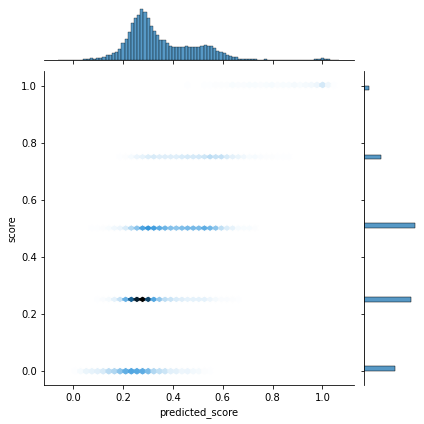

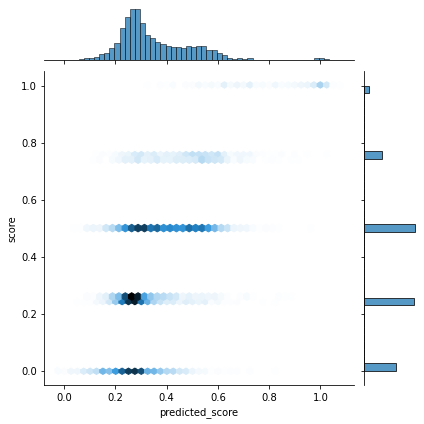

In [5]:
# Evaluate
print("Feature importance")
for e in sorted(zip(cols, model.get_feature_importance()), key=lambda x: -x[1]):
    print(f"\t{e[0]}: {e[1]}")
    
def _pretty_print_score(model, tag, df):
    corr = np.corrcoef(df["score"], df["predicted_score"])[0][1]
    print(f"{tag}:\n\t{corr}")
    sns.jointplot(x=df["predicted_score"], y=df["score"], kind="hex")

train["predicted_score"] = model.predict(train[cols])
_pretty_print_score(model, "train", train)

test["predicted_score"] = model.predict(test[cols])
_pretty_print_score(model, "test", test)
